## Background Removal

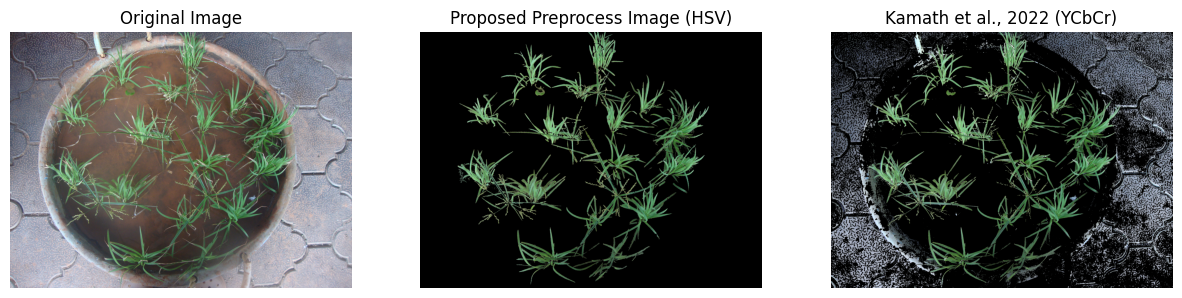

In [12]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt


##################################Proposed Approach##########################################
input_folder = 'dataset_fyp/total_original'
filename = 'DSC04276.JPG'  

input_path = os.path.join(input_folder, filename)

image = cv2.imread(input_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

lower_green = np.array([30, 40, 40]) 
upper_green = np.array([80, 255, 255])  


hsv_mask = cv2.inRange(hsv_image, lower_green, upper_green)

mask1 = np.zeros_like(hsv_mask, dtype=np.uint8)
contours, _ = cv2.findContours(hsv_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contours):
    areaContour = cv2.contourArea(c)
    if areaContour < 1000:
        continue
    cv2.drawContours(mask1, contours, i, (255), thickness=cv2.FILLED)
outImg_filtered = cv2.bitwise_and(hsv_mask, mask1)

result_hsv = cv2.bitwise_and(image, image, mask=outImg_filtered)

##############################Baseline Approach#####################################################
ycbcr_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
_, cr_channel, _ = cv2.split(ycbcr_image)

_, cr_thresh = cv2.threshold(cr_channel, 125, 255, cv2.THRESH_BINARY_INV)
cr_thresh = cv2.bitwise_and(cr_thresh, cr_thresh, mask=(cr_channel > 0).astype(np.uint8))

result_ycbcr = cv2.bitwise_and(image, image, mask=cr_thresh)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(result_hsv)
plt.title('Proposed Preprocess Image (HSV)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(result_ycbcr)
plt.title('Kamath et al., 2022 (YCbCr)')
plt.axis('off')

plt.show()


## Pixel Mapping 

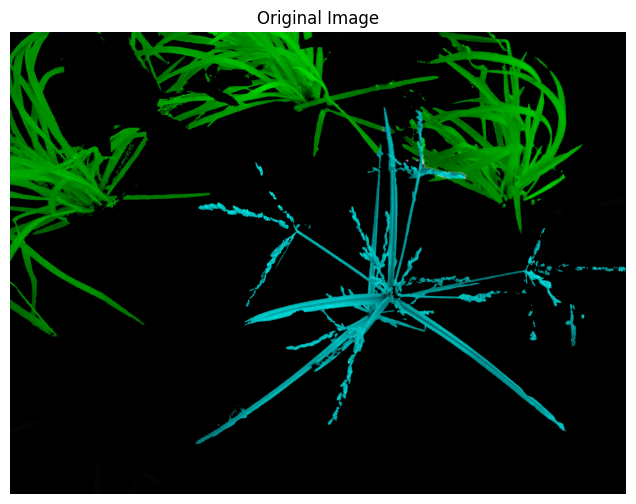

Processed and saved: dataset_fyp/demo\DSC04313.JPG


In [22]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# Define color ranges and corresponding values
color_ranges = {
    'green': ([0, 120, 0], [50, 255, 50]),
    'red': ([128, 0, 0], [255, 30, 30]),
    'blue': ([0, 0, 128], [30, 30, 255]),
    'cyan': ([0, 128, 128], [100, 255, 255])
}

color_to_value = {
    'green': 1,
    'blue': 2,
    'red': 3,
    'cyan': 4
}

def extract_color_mask(image, color_name):
    lower, upper = color_ranges[color_name]
    lower = np.array(lower, dtype=np.uint8)
    upper = np.array(upper, dtype=np.uint8)
    mask = cv2.inRange(image, lower, upper)
    return mask

def process_and_save_image(input_folder, filename, output_folder):
    # Load the mask image
    input_path = os.path.join(input_folder, filename)
    mask_image = cv2.imread(input_path)
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
    
    # Display the original image
    plt.figure(figsize=(8, 6))
    plt.imshow(mask_image)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    labeled_mask = np.zeros(mask_image.shape[:2], dtype=np.uint8)

    for color_name, value in color_to_value.items():
        mask = extract_color_mask(mask_image, color_name)
        labeled_mask[mask > 0] = value

    # Save the labeled mask
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, labeled_mask)
    print(f"Processed and saved: {output_path}")

input_folder = 'dataset_fyp/annotated'
output_folder = 'dataset_fyp/demo'
filename = 'DSC04313.JPG' 

process_and_save_image(input_folder, filename, output_folder)


### Data Augmentation 

In [ ]:
DSC04313
import os
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm
import random

# Define augmentations 
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    A.SomeOf([
        A.HueSaturationValue(
            hue_shift_limit=0,
            sat_shift_limit=35,
            val_shift_limit=0
        ),
        A.RandomBrightnessContrast(
            brightness_limit=0.4,
            contrast_limit=0.25,
            p=0.2
        )
    ], n=1, p=0.5),
    A.OneOf([
        A.GaussNoise(p=1.0),
        A.CLAHE(p=1.0),
        A.RandomGamma(p=1.0),
    ], p=0.2),
    A.OneOf([
        A.Blur(blur_limit=3, p=1.0),
        A.MotionBlur(blur_limit=3, p=1.0),
        A.MedianBlur(blur_limit=3, p=0.25)
    ], p=0.2),
], additional_targets={'mask': 'mask'})

def calculate_exg(image):
    B, G, R = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    ExG = 2 * G - R - B
    return ExG


def calculate_exr(image):
    B, G, R = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    ExR = 1.4 * R - G
    return ExR


def calculate_cive(image):
    B, G, R = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    CIVE = 0.441 * R - 0.811 * G + 0.385 * B + 18.787
    return CIVE

def save_random_vegetation_index(image, base_name, save_dir):
    index_type = random.choice(['ExG', 'ExR', 'CIVE'])
    if index_type == 'ExG':
        index_image = calculate_exg(image)
    elif index_type == 'ExR':
        index_image = calculate_exr(image)
    else:
        index_image = calculate_cive(image)
    

    index_image = cv2.normalize(index_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    index_filename = f"{base_name}_{index_type}.jpg"
    cv2.imwrite(os.path.join(save_dir, index_filename), index_image)
    
    return index_filename


def copy_mask_with_new_filenames(augmented_mask_path, target_dir, new_filename):
    new_mask_path = os.path.join(target_dir, new_filename)
    cv2.imwrite(new_mask_path, cv2.imread(augmented_mask_path, cv2.IMREAD_GRAYSCALE))


def augment_images(folder_path, target_count, aug_images_path, aug_masks_path, aug_indices_path, copy_masks_path):
    # Get a list of all image files in the folder
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    original_count = len(images)

    print(f"Original count for {folder_path}: {original_count}")

    if original_count == 0:
        print(f"No images found in {folder_path}")
        return

    augmentations_per_image = (target_count - original_count) // original_count

    os.makedirs(aug_images_path, exist_ok=True)
    os.makedirs(aug_masks_path, exist_ok=True)
    os.makedirs(aug_indices_path, exist_ok=True)
    os.makedirs(copy_masks_path, exist_ok=True)

    for image_file in tqdm(images):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        mask_path = os.path.join(folder_path.replace("images", "masks"), image_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        base_name = os.path.splitext(image_file)[0]
        aug_image_path = os.path.join(aug_images_path, f"{base_name}.jpg")
        aug_mask_path = os.path.join(aug_masks_path, f"{base_name}.jpg")
        cv2.imwrite(aug_image_path, image)
        cv2.imwrite(aug_mask_path, mask)
        index_filename = save_random_vegetation_index(image, base_name, aug_indices_path)
        copy_mask_with_new_filenames(aug_mask_path, copy_masks_path, index_filename)

        for i in range(augmentations_per_image):
            augmented = transform(image=image, mask=mask)
            aug_image = augmented['image']
            aug_mask = augmented['mask']

            aug_image_file = f"aug_{i}_{base_name}"
            aug_image_path = os.path.join(aug_images_path, f"{aug_image_file}.jpg")
            aug_mask_path = os.path.join(aug_masks_path, f"{aug_image_file}.jpg")

            cv2.imwrite(aug_image_path, aug_image)
            cv2.imwrite(aug_mask_path, aug_mask)


            index_filename = save_random_vegetation_index(aug_image, aug_image_file, aug_indices_path)

   
            copy_mask_with_new_filenames(aug_mask_path, copy_masks_path, index_filename)

    print(f"Augmented count for {folder_path}: {target_count}")


folder_paths = {
    'paddy': 2718
}
base_path = "dataset_fyp/masks_separated"


for folder_name, target_count in folder_paths.items():
    folder_path = os.path.join(base_path, "images", folder_name)
    aug_images_path = os.path.join(base_path, "augmented_images", folder_name)
    aug_masks_path = os.path.join(base_path, "augmented_masks", folder_name)
    aug_indices_path = os.path.join(base_path, "augmented_indices", folder_name)
    copy_masks_path = os.path.join(base_path, "augmented_indices_masks", folder_name)
    augment_images(folder_path, target_count, aug_images_path, aug_masks_path, aug_indices_path, copy_masks_path)


## MODEL TRAINING

In [ ]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
import fnmatch

from keras.utils import normalize
from keras.metrics import MeanIoU


## Single-Class Images (Over a Multiclass Model)

In [ ]:
SIZE_X = 384 
SIZE_Y = 384
n_classes= 5 

img_directories = [
    "dataset_fyp/semseg/paddy_single_class",
    "dataset_fyp/semseg/broad_single_class",
    "dataset_fyp/semseg/sedges_single_class",
    "dataset_fyp/semseg/grass_single_class"
]

train_images = []

# Read images from the specified directories
for directory in img_directories:
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.JPG')):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, 1)
            img = cv2.resize(img, (SIZE_Y, SIZE_X))
            train_images.append(img)

train_images = np.array(train_images)
mask_directories = [
    "dataset_fyp/semseg/paddy_single_class_mask",
    "dataset_fyp/semseg/broad_single_class_mask",
    "dataset_fyp/semseg/sedges_single_class_mask",
    "dataset_fyp/semseg/grass_single_class_mask"
]

train_masks = []
for directory in mask_directories:
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.JPG')):
            mask_path=os.path.join(directory,filename)
            mask = cv2.imread(mask_path, 0)
            mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
            mask = np.where((mask >= 0) & (mask <= 4), mask, 0)
            train_masks.append(mask)

train_masks = np.array(train_masks)
train_masks_input = np.expand_dims(train_masks, axis=3)
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.20, random_state=0)
from sklearn.utils import shuffle
aug_directories = [
    "dataset_fyp/semseg/paddy_indices",
    "dataset_fyp/semseg/broad_indices",
    "dataset_fyp/semseg/sedges_indices",
    "dataset_fyp/semseg/grass_indices"
]

augmask_directories = [
    "dataset_fyp/semseg/paddy_indices_mask",
    "dataset_fyp/semseg/broad_indices_mask",
    "dataset_fyp/semseg/sedges_indices_mask",
    "dataset_fyp/semseg/grass_indices_mask"
]

def load_images_from_directories(directories, size_x, size_y):
    images = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith(('.jpg', '.JPG')):
                img_path = os.path.join(directory, filename)
                img = cv2.imread(img_path, 1)
                img = cv2.resize(img, (size_y, size_x))
                images.append(img)
    return np.array(images)

# Function to load masks
def load_masks_from_directories(directories, size_x, size_y):
    masks = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith(('.jpg', '.JPG')):
                mask_path = os.path.join(directory, filename)
                mask = cv2.imread(mask_path, 0)
                mask = cv2.resize(mask, (size_y, size_x), interpolation=cv2.INTER_NEAREST)
                mask = np.where((mask >= 0) & (mask <= 4), mask, 0)
                masks.append(mask)
    return np.array(masks)

# Load augmented images and masks
aug_images = load_images_from_directories(aug_directories, SIZE_X, SIZE_Y)
aug_masks = load_masks_from_directories(augmask_directories, SIZE_X, SIZE_Y)
aug_masks_input = np.expand_dims(aug_masks, axis=3)

# Append augmented data to the training set
X_train = np.concatenate((X_train, aug_images), axis=0)
y_train = np.concatenate((y_train, aug_masks_input), axis=0)

# Shuffle the training set
X_train, y_train = shuffle(X_train, y_train, random_state=0)


from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
SIZE_X = 384 
SIZE_Y = 384
n_classes= 5 

img_directories = [
    "dataset_fyp/semseg/paddy_single_class",
    "dataset_fyp/semseg/broad_single_class",
    "dataset_fyp/semseg/sedges_single_class",
    "dataset_fyp/semseg/grass_single_class"
]

train_images = []

# Read images from the specified directories
for directory in img_directories:
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.JPG')):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, 1)
            img = cv2.resize(img, (SIZE_Y, SIZE_X))
            train_images.append(img)

train_images = np.array(train_images)
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.20, random_state=0)
                           

In [ ]:
mask_directories = [
    "dataset_fyp/semseg/paddy_single_class_mask",
    "dataset_fyp/semseg/broad_single_class_mask",
    "dataset_fyp/semseg/sedges_single_class_mask",
    "dataset_fyp/semseg/grass_single_class_mask"
]

train_masks = []
for directory in mask_directories:
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.JPG')):
            mask_path=os.path.join(directory,filename)
            mask = cv2.imread(mask_path, 0)
            mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
            mask = np.where((mask >= 0) & (mask <= 4), mask, 0)
            train_masks.append(mask)

train_masks = np.array(train_masks)

In [ ]:
train_masks_input = np.expand_dims(train_masks, axis=3)
train_masks_input.shape

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.20, random_state=0)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

In [ ]:
from sklearn.utils import shuffle
aug_directories = [
    "dataset_fyp/semseg/paddy_indices",
    "dataset_fyp/semseg/broad_indices",
    "dataset_fyp/semseg/sedges_indices",
    "dataset_fyp/semseg/grass_indices"
]

augmask_directories = [
    "dataset_fyp/semseg/paddy_indices_mask",
    "dataset_fyp/semseg/broad_indices_mask",
    "dataset_fyp/semseg/sedges_indices_mask",
    "dataset_fyp/semseg/grass_indices_mask"
]

def load_images_from_directories(directories, size_x, size_y):
    images = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith(('.jpg', '.JPG')):
                img_path = os.path.join(directory, filename)
                img = cv2.imread(img_path, 1)
                img = cv2.resize(img, (size_y, size_x))
                images.append(img)
    return np.array(images)

# Function to load masks
def load_masks_from_directories(directories, size_x, size_y):
    masks = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith(('.jpg', '.JPG')):
                mask_path = os.path.join(directory, filename)
                mask = cv2.imread(mask_path, 0)
                mask = cv2.resize(mask, (size_y, size_x), interpolation=cv2.INTER_NEAREST)
                mask = np.where((mask >= 0) & (mask <= 4), mask, 0)
                masks.append(mask)
    return np.array(masks)

# Load augmented images and masks
aug_images = load_images_from_directories(aug_directories, SIZE_X, SIZE_Y)
aug_masks = load_masks_from_directories(augmask_directories, SIZE_X, SIZE_Y)
aug_masks_input = np.expand_dims(aug_masks, axis=3)

# Append augmented data to the training set
X_train = np.concatenate((X_train, aug_images), axis=0)
y_train = np.concatenate((y_train, aug_masks_input), axis=0)

# Shuffle the training set
X_train, y_train = shuffle(X_train, y_train, random_state=0)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


In [ ]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"y_test_cat shape: {y_test_cat.shape}")

In [ ]:
######################################################
#Reused parameters in all models

n_classes=5
activation='softmax'

LR = 0.001
optim = keras.optimizers.Adam(LR)


loss = sm.losses.CategoricalCELoss(class_weights=None)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(threshold=0.5), sm.metrics.Recall(threshold=0.5)]

In [ ]:
###Model 1
BACKBONE1 = 'resnet50'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.PSPNet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimizer, loss and metrics
model1.compile(optim, loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001)

# Fit the model with both callbacks
with tf.device('/cpu:0'):
    history1 = model1.fit(X_train1, 
                          y_train_cat,
                          batch_size=32, 
                          epochs=50,
                          verbose=1,
                          validation_data=(X_test1, y_test_cat),
                          callbacks=[early_stopping, reduce_lr]
                         )

# Save the model after training
model1.save('PSPNet_renet50_single_class.hdf5')


In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
#Unet
###Model 1
BACKBONE1 = 'resnet50'
preprocess_input2 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

# define model
modelu2 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimizer, loss and metrics
modelu2.compile(optim, loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(modelu2.summary())

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001)

# Fit the model with both callbacks
with tf.device('/cpu:0'):
    historyu2 = modelu2.fit(X_train2, 
                          y_train_cat,
                          batch_size=16, 
                          epochs=50,
                          verbose=1,
                          validation_data=(X_test2, y_test_cat),
                          callbacks=[early_stopping, reduce_lr]
                         )

# Save the model after training
modelu2.save('Unet_renet50_single_class.hdf5')


In [ ]:
modelu2.save('Unet_renet50_single_class.hdf5')

## Multi-Class Images


In [1]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
import fnmatch

from keras.utils import normalize
from keras.metrics import MeanIoU


Segmentation Models: using `keras` framework.


In [10]:
SIZE_X = 384 
SIZE_Y = 384
n_classes= 5 

img_directories = ["dataset_fyp/semseg/images_new"]

train_images = []

# Read images from the specified directories
for directory in img_directories:
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.JPG')):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, 1)
            img = cv2.resize(img, (SIZE_Y, SIZE_X))
            train_images.append(img)

train_images = np.array(train_images)

In [11]:
train_masks = []
for filename in os.listdir("dataset_fyp/semseg/masks_newest"):
    if filename.endswith(('.jpg','.JPG')):
        mask_path = os.path.join("dataset_fyp/semseg/masks_newest",filename)

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
        mask = np.where((mask >= 0) & (mask <= 4), mask, 0)
        train_masks.append(mask)

train_masks = np.array(train_masks)
                           

In [12]:
train_masks_input = np.expand_dims(train_masks, axis=3)
train_masks_input.shape

(1310, 384, 384, 1)

In [13]:
from sklearn.model_selection import train_test_split
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.20, random_state=0)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1048, 384, 384, 3)
X_test shape: (262, 384, 384, 3)
y_train shape: (1048, 384, 384, 1)
y_test shape: (262, 384, 384, 1)


In [14]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [15]:
print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"y_test_cat shape: {y_test_cat.shape}")

y_train_cat shape: (1048, 384, 384, 5)
y_test_cat shape: (262, 384, 384, 5)


## SegNet

In [ ]:
# Define the SegNet model
def segnet(input_size=(256, 256, 3), n_classes=5):
    inputs = keras.layers.Input(input_size)

    # Encoder
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization()(x)
    pool_1 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool_1)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization()(x)
    pool_2 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool_2)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization()(x)
    pool_3 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool_3)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization()(x)
    pool_4 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool_4)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization()(x)
    pool_5 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Decoder
    unpool_1 = keras.layers.UpSampling2D(size=(2, 2))(pool_5)
    conv_14 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(unpool_1)
    conv_15 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv_14)
    conv_16 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv_15)
    conv_16 = keras.layers.BatchNormalization()(conv_16)

    unpool_2 = keras.layers.UpSampling2D(size=(2, 2))(conv_16)
    conv_17 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(unpool_2)
    conv_18 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv_17)
    conv_19 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv_18)
    conv_19 = keras.layers.BatchNormalization()(conv_19)

    unpool_3 = keras.layers.UpSampling2D(size=(2, 2))(conv_19)
    conv_20 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(unpool_3)
    conv_21 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv_20)
    conv_22 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv_21)
    conv_22 = keras.layers.BatchNormalization()(conv_22)

    unpool_4 = keras.layers.UpSampling2D(size=(2, 2))(conv_22)
    conv_23 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(unpool_4)
    conv_24 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv_23)
    conv_24 = keras.layers.BatchNormalization()(conv_24)

    unpool_5 = keras.layers.UpSampling2D(size=(2, 2))(conv_24)
    conv_25 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(unpool_5)
    conv_26 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv_25)
    conv_26 = keras.layers.BatchNormalization()(conv_26)
    
    out = keras.layers.Conv2D(n_classes, (1, 1), activation='softmax', padding='same', kernel_initializer='he_normal')(conv_26)
    print("Build decoder done..")
    model = keras.models.Model(inputs=inputs, outputs=out, name="SegNet")
    return model

In [ ]:
# Initialize the SegNet model
model = segnet(input_size=(SIZE_X, SIZE_Y, 3), n_classes=n_classes)
model.summary()

# Compile the model using the previously defined loss and metrics
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)



In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

n_classes=5
activation='softmax'

LR = 0.001
optim = keras.optimizers.Adam(LR)
modelsegnet1 = load_model('SegNet.hdf5', compile=False)
optim = keras.optimizers.Adam(LR)
loss = sm.losses.CategoricalCELoss(class_weights=[0.5, 1,2,2,2])
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(threshold=0.5), sm.metrics.Recall(threshold=0.5)]


# Compile the model
modelsegnet1.compile(optim,
              loss,
              metrics=metrics)


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001)
with tf.device('/cpu:0'):
    historysegnet2= modelsegnet1.fit(X_train,
                                     y_train_cat,
                                     validation_data=(X_test,y_test_cat),
                                     batch_size=4,
                                     epochs=50,
                                     verbose=1, 
                                     callbacks=[reduce_lr])
modelsegnet1.save('SegNet_multiclass_50ep.hdf5')

In [ ]:
###Model 1
LR = 0.001
optim = keras.optimizers.Adam(LR)
activation='softmax'
BACKBONE1 = 'resnet50'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train2 = preprocess_input1(X_train)
X_test2 = preprocess_input1(X_test)
loss = sm.losses.CategoricalCELoss(class_weights=[0.5, 1,2,2,2])

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(threshold=0.5), sm.metrics.Recall(threshold=0.5)]



## PSPNet

In [ ]:
######################################################
#Reused parameters in all models

n_classes=5
from tensorflow.keras.models import load_model
modelpspnet = load_model('PSPNet_renet50_single_class.hdf5', compile=False)
modelpspnet.compile(optim, loss, metrics=metrics)

# Load the model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001)

# Fit the model with both callbacks
with tf.device('/cpu:0'):
    historypsp2 = modelpspnet.fit(X_train2, 
                          y_train_cat,
                          batch_size=32, 
                          epochs=100,
                          verbose=1,
                          validation_data=(X_test2, y_test_cat),
                          callbacks=[early_stopping, reduce_lr]
                         )
# Save the model after training
modelpspnet.save('PSPNet_renet50_multi_class.hdf5')



In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = historypsp2.history['loss']
val_loss = historypsp2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = historypsp2.history['iou_score']
val_acc = historypsp2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

## UNet MultiClass

In [ ]:
######################################################
#Reused parameters in all models

n_classes=5
from tensorflow.keras.models import load_model
modelunet2 = load_model('Unet_renet50_single_class.hdf5', compile=False)
modelunet2.compile(optim, loss, metrics=metrics)

# Load the model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001)

# Fit the model with both callbacks
with tf.device('/cpu:0'):
    historyunet2 = modelunet2.fit(X_train2, 
                          y_train_cat,
                          batch_size=16, 
                          epochs=100,
                          verbose=1,
                          validation_data=(X_test2, y_test_cat),
                          callbacks=[early_stopping, reduce_lr]
                         )
# Save the model after training
modelunet2.save('Unet_renet50_multi_class.hdf5')



In [ ]:
######################################################
#Reused parameters in all models

n_classes=5
from tensorflow.keras.models import load_model
modelunet4 = load_model('Unet_renet50_multi_class_100ep.hdf5', compile=False)
modelunet4.compile(optim, loss, metrics=metrics)

# Load the model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the early stopping callback

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001)

# Fit the model with both callbacks
with tf.device('/cpu:0'):
    historyunet4 = modelunet4.fit(X_train2, 
                          y_train_cat,
                          batch_size=16, 
                          epochs=28,
                          verbose=1,
                          validation_data=(X_test2, y_test_cat),
                          callbacks=[reduce_lr]
                         )
# Save the model after training
modelunet4.save('Unet_renet50_multi_class_100ep28.hdf5')



In [ ]:
import matplotlib.pyplot as plt

# Extract the metrics from the first history
loss4 = historyunet2.history['loss']
val_loss4 = historyunet2.history['val_loss']
iou4 = historyunet2.history['iou_score']
val_iou4 = historyunet2.history['val_iou_score']

# Extract the metrics from the second history
loss5 = historyunet3.history['loss']
val_loss5 = historyunet3.history['val_loss']
iou5 = historyunet3.history['iou_score']
val_iou5 = historyunet3.history['val_iou_score']

loss6 = historyunet4.history['loss']
val_loss6 = historyunet4.history['val_loss']
iou6 = historyunet4.history['iou_score']
val_iou6 = historyunet4.history['val_iou_score']

# Concatenate the metrics from both histories
combined_loss = loss4 + loss5 + loss6
combined_val_loss = val_loss4 + val_loss5 + val_loss6
combined_iou = iou4 + iou5 + iou6
combined_val_iou = val_iou4 + val_iou5 + val_iou6

# Generate the epochs for the combined histories
epochs = range(1, len(combined_loss) + 1)

# Plot the combined training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, combined_loss, 'y', label='Training loss')
plt.plot(epochs, combined_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the combined training and validation IOU
plt.figure(figsize=(10, 5))
plt.plot(epochs, combined_iou, 'y', label='Training IOU')
plt.plot(epochs, combined_val_iou, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
#Test some random images
import random
BACKBONE2 = 'resnet50'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)
model2 = load_model('PSPNet_renet50_multi_class.hdf5', compile=False)
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input2(test_img_input)

test_pred1 = model2.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
from tensorflow.keras.models import load_model

# Set the backbone and preprocessing function
BACKBONE2 = 'resnet50'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# Preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)
model2 = load_model('100epochs_withnewimagesv2.hdf5', compile=False)

# Select a specific test image by index
test_img_number = 112# Change this to the index of the desired image
test_img = X_test2[test_img_number]
ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

# Predict on the test image
test_pred1 = model2.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0, :, :]

# Create a color map for different classes for the prediction
prediction_colors = np.array([
    [0, 0, 0],    # Background: Black
    [0, 0, 255],  # Class 1 (Paddy): Blue
    [255, 0, 255],  # Class 2 (Broadleaved): Magenta
    [0, 255, 0],  # Class 3 (Grass): Green
    [255, 0, 255]  # Class 4 (Sedges): Magenta (if applicable)
])

# Create a color map for the ground truth
ground_truth_colors = np.array([
    [0, 0, 0],    # Background: Black
    [0, 255, 0],  # Class 1 (Paddy): Green
    [0, 0, 255],  # Class 2 (Broadleaved): Blue
    [255, 0, 0],  # Class 3 (Grass): Red
    [255, 0, 255]  # Class 4 (Sedges): Magenta
])

# Function to apply color map to the predicted mask
def apply_color_map(mask, colors):
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(n_classes):
        colored_mask[mask == i] = colors[i]
    return colored_mask

# Apply color map to the ground truth and prediction
ground_truth_colored = apply_color_map(ground_truth[:, :, 0], ground_truth_colors)
prediction_colored = apply_color_map(test_prediction1, prediction_colors)

# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_colored)
plt.axis('off')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction_colored)
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
from tensorflow.keras.models import load_model

# Set the backbone and preprocessing function
BACKBONE2 = 'resnet50'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# Preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)
model2 = load_model('Unet_renet50_multi_class_100ep28.hdf5', compile=False)

# Select a specific test image by index
test_img_number = 112 # Change this to the index of the desired image
test_img = X_test2[test_img_number]
ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

# Predict on the test image
test_pred1 = model2.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0, :, :]

# Create a color map for different classes
n_classes = 5  # Update to your number of classes
colors = np.array([
    [0, 0, 0],    # Background: Black
    [0, 255, 0],  # Class 1 (Paddy): Green
    [0, 0, 255],  # Class 2 (Broadleaved): Blue
    [255, 0, 0],  # Class 3 (Grass): Red
    [255, 0, 255] # Class 4 (Sedges): Magenta
])

# Function to apply color map to the predicted mask
def apply_color_map(mask, colors):
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(n_classes):
        colored_mask[mask == i] = colors[i]
    return colored_mask

# Apply color map to the ground truth and prediction
ground_truth_colored = apply_color_map(ground_truth[:, :, 0], colors)
prediction_colored = apply_color_map(test_prediction1, colors)

# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_colored)
plt.axis('off')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction_colored)
plt.axis('off')

# # Add legend
# class_names = ['Background', 'Paddy', 'Broadleaved', 'Grass', 'Sedges']
# patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color)/255.0, markersize=10)
#            for color in colors]
# plt.legend(patches, class_names, loc='upper right', bbox_to_anchor=(1.4, 1))

plt.tight_layout()
plt.show()


In [ ]:
output_dir = 'output_images'
os.makedirs(output_dir, exist_ok=True)

plt.savefig(os.path.join(output_dir, f'prediction_{test_img_number}.png'))
plt.show()

## Herbicide Recommender

1/1 [==============================] - 1s 687ms/step


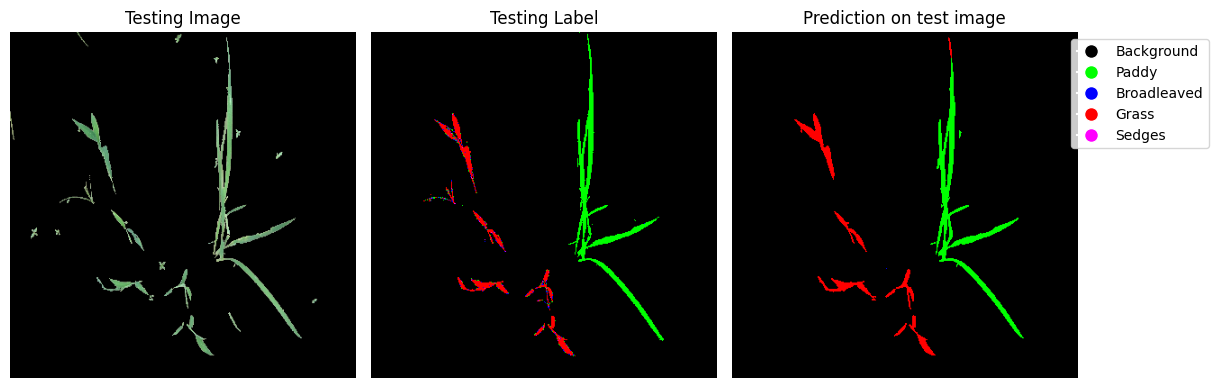

---------------Weed Percentage/Herbicide Recommendation-------------------
Broadleaved pixel percentage: 0.00%
Weed percentage for Broadleaved is below threshold. No herbicides recommended.
Grass pixel percentage: 1.25%
Grass: Recommended herbicides are Quinclorac or Fenoxaprop-p-ethyl.


In [24]:
import random
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
from tensorflow.keras.models import load_model


BACKBONE2 = 'resnet50'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)
model2 = load_model('Unet_renet50_multi_class_100ep28.hdf5', compile=False)

# testing
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

# Predict 
test_pred1 = model2.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0, :, :]


n_classes = 5  
colors = np.array([
    [0, 0, 0],    # Background: Black
    [0, 255, 0],  # Class 1 (Paddy): Green
    [0, 0, 255],  # Class 2 (Broad): Blue
    [255, 0, 0],  # Class 3 (Grass): Red
    [255, 0, 255]  # Class 4 (Sedges): Magenta
])

# Function to apply color map to the predicted mask
def apply_color_map(mask, colors):
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(n_classes):
        colored_mask[mask == i] = colors[i]
    return colored_mask

# Apply color map to the ground truth and prediction
ground_truth_colored = apply_color_map(ground_truth[:, :, 0], colors)
prediction_colored = apply_color_map(test_prediction1, colors)

# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_colored)
plt.axis('off')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction_colored)
plt.axis('off')


class_names = ['Background', 'Paddy', 'Broadleaved', 'Grass', 'Sedges']
patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color)/255.0, markersize=10)
           for color in colors]
plt.legend(patches, class_names, loc='upper right', bbox_to_anchor=(1.4, 1))

plt.tight_layout()
plt.show()

print("---------------Weed Percentage/Herbicide Recommendation-------------------")
n_classes = 5  
class_pixel_counts = np.bincount(test_prediction1.flatten(), minlength=n_classes)
total_pixels = test_prediction1.size
class_pixel_percentages = (class_pixel_counts / total_pixels) * 100

threshold = 0.5
herbicide_recommendations = {
    2: "Broadleaved: Recommended herbicides are 2,4-D or MCPA.",
    3: "Grass: Recommended herbicides are Quinclorac or Fenoxaprop-p-ethyl.",
    4: "Sedges: Recommended herbicides are Halosulfuron or Sulfentrazone."
}


for class_idx in range(2, n_classes):
    percentage = class_pixel_percentages[class_idx]
    class_name = class_names[class_idx]
    if percentage > 0:
        print(f"{class_name} pixel percentage: {percentage:.2f}%")
        if percentage > threshold:
            print(herbicide_recommendations[class_idx])
        else:
            print(f"Weed percentage for {class_name} is below threshold. No herbicides recommended.")


1/1 [==============================] - 1s 1s/step


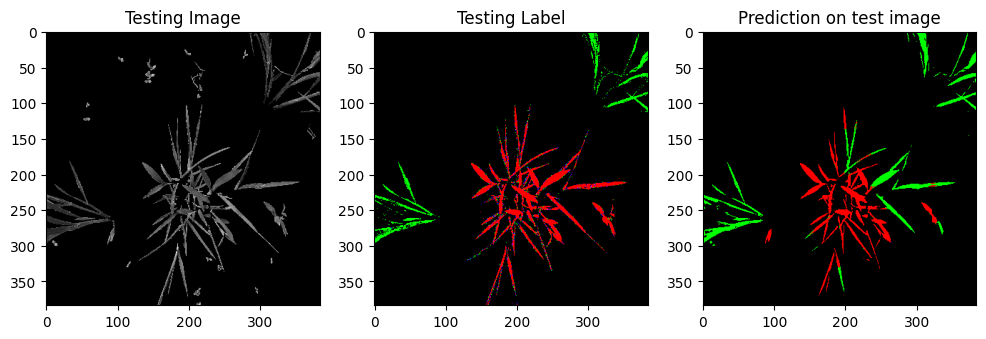

Background: Black
Paddy: Green
Broadleaved: Blue
Grass: Red
---------------Weed Percentage/Herbicide Recommendation-------------------
Broadleaved pixel percentage: 0.00%
Weed percentage for Broadleaved is below threshold. No herbicides recommended.
Grass pixel percentage: 2.85%
Grass: Recommended herbicides are Quinclorac or Fenoxaprop-p-ethyl.


In [32]:
import random
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
from tensorflow.keras.models import load_model

# Set the backbone and preprocessing function
BACKBONE2 = 'resnet50'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)
model2 = load_model('Unet_renet50_multi_class_100ep28.hdf5', compile=False)

test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)


test_pred1 = model2.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0, :, :]


n_classes = 5  
colors = np.array([
    [0, 0, 0],    
    [0, 255, 0],  # Class 1 (Paddy): Green
    [0, 0, 255],  # Class 2 (Broad): Blue
    [255, 0, 0],  # Class 3 (Grass): Red
    [255, 0, 255]  # Class 4 (Sedges): Cyan
])

color_names = {
    (0, 0, 0): "Black",
    (0, 255, 0): "Green",
    (0, 0, 255): "Blue",
    (255, 0, 0): "Red",
    (255, 0, 255): "Magenta"
}

# Function to apply color map to the predicted mask
def apply_color_map(mask, colors):
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(n_classes):
        colored_mask[mask == i] = colors[i]
    return colored_mask

ground_truth_colored = apply_color_map(ground_truth[:, :, 0], colors)
prediction_colored = apply_color_map(test_prediction1, colors)

# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_colored)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction_colored)
plt.show()

# Print which mask belongs to which class
class_names = ['Background', 'Paddy', 'Broadleaved', 'Grass', 'Sedges']  
unique_classes = np.unique(test_prediction1)
for cls in unique_classes:
    color_tuple = tuple(colors[cls])
    color_name = color_names[color_tuple]
    print(f"{class_names[cls]}: {color_name}")

print("---------------Weed Percentage/Herbicide Recommendation-------------------")
n_classes = 5  
class_pixel_counts = np.bincount(test_prediction1.flatten(), minlength=n_classes)
total_pixels = test_prediction1.size
class_pixel_percentages = (class_pixel_counts / total_pixels) * 100

threshold = 0.5 
herbicide_recommendations = {
    2: "Broadleaved: Recommended herbicides are 2,4-D or MCPA.",
    3: "Grass: Recommended herbicides are Quinclorac or Fenoxaprop-p-ethyl.",
    4: "Sedges: Recommended herbicides are Halosulfuron or Sulfentrazone."
}


for class_idx in range(2, n_classes):
    percentage = class_pixel_percentages[class_idx]
    class_name = class_names[class_idx]
    if percentage > 0:
        print(f"{class_name} pixel percentage: {percentage:.2f}%")
        if percentage > threshold:
            print(herbicide_recommendations[class_idx])
        else:
            print(f"Weed percentage for {class_name} is below threshold. No herbicides recommended.")


In [ ]:

n_classes = 5  # Number of classes
class_pixel_counts = np.bincount(test_prediction1.flatten(), minlength=n_classes)
total_pixels = test_prediction1.size
class_pixel_percentages = (class_pixel_counts / total_pixels) * 100


threshold = 1  
herbicide_recommendations = {
    2: "Grass: Recommended herbicides are Quinclorac or Fenoxaprop-p-ethyl.",
    3: "Sedges: Recommended herbicides are Halosulfuron or Sulfentrazone.",
    4: "Broadleaved plants: Recommended herbicides are 2,4-D or MCPA."
}


for class_idx in range(2, n_classes):
    percentage = class_pixel_percentages[class_idx]
    print(f"Class {class_idx} pixel percentage: {percentage:.2f}%")
    if percentage > threshold:
        print(herbicide_recommendations[class_idx])


## Model Evaluation

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU

model2 = load_model('Unet_renet50_multi_class_100ep28.hdf5', compile=False)

with tf.device('/cpu:0'):
    y_pred1 = model2.predict(X_test2)
    y_pred1_argmax = np.argmax(y_pred1, axis=3)

# Using built-in Keras function
    n_classes = 5
    IOU_keras = MeanIoU(num_classes=n_classes)
    IOU_keras.update_state(y_test[:, :, :, 0], y_pred1_argmax)
    print("Mean IoU =", IOU_keras.result().numpy())
    
    # To calculate IoU for each class
    values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
    print(values)
    class1_IoU = values[0, 0] / (values[0, 0] + values[0, 1] + values[0, 2] + values[0, 3] + values[0, 4] + values[1, 0] + values[2, 0] + values[3, 0] + values[4, 0])
    class2_IoU = values[1, 1] / (values[1, 1] + values[1, 0] + values[1, 2] + values[1, 3] + values[1, 4] + values[0, 1] + values[2, 1] + values[3, 1] + values[4, 1])
    class3_IoU = values[2, 2] / (values[2, 2] + values[2, 0] + values[2, 1] + values[2, 3] + values[2, 4] + values[0, 2] + values[1, 2] + values[3, 2] + values[4, 2])
    class4_IoU = values[3, 3] / (values[3, 3] + values[3, 0] + values[3, 1] + values[3, 2] + values[3, 4] + values[0, 3] + values[1, 3] + values[2, 3] + values[4, 3])
    class5_IoU = values[4, 4] / (values[4, 4] + values[4, 0] + values[4, 1] + values[4, 2] + values[4, 3] + values[0, 4] + values[1, 4] + values[2, 4] + values[3, 4])
    
    print("IoU for class1 is: ", class1_IoU)
    print("IoU for class2 is: ", class2_IoU)
    print("IoU for class3 is: ", class3_IoU)
    print("IoU for class4 is: ", class4_IoU)
    print("IoU for class5 is: ", class5_IoU)


9/9 [==============================] - 53s 5s/step
Mean IoU = 0.563805
[[1.6777216e+07 5.9290100e+05 3.6166000e+04 3.9699000e+04 2.8895000e+04]
 [4.1317600e+05 2.4211590e+06 9.0450000e+03 2.4249000e+04 1.3221000e+04]
 [5.3491000e+04 2.2484000e+04 1.1173300e+05 2.3357000e+04 3.3570000e+03]
 [4.6580000e+04 4.0051000e+04 6.5230000e+03 1.5065800e+05 1.1183000e+04]
 [2.4534000e+04 2.1825000e+04 1.9600000e+02 6.7980000e+03 6.0837000e+04]]
IoU for class1 is:  0.9314126
IoU for class2 is:  0.6804619
IoU for class3 is:  0.41949376
IoU for class4 is:  0.43156362
IoU for class5 is:  0.35609263


In [12]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Predict and get argmax
with tf.device('/cpu:0'):
    y_pred1 = model2.predict(X_test2)
    y_pred1_argmax = np.argmax(y_pred1, axis=3)

    # Flatten the arrays for metric calculations
    y_test_flat = y_test[:,:,:,0].flatten()
    y_pred_flat = y_pred1_argmax.flatten()
    
    accuracy = accuracy_score(y_test_flat, y_pred_flat)
    precision = precision_score(y_test_flat, y_pred_flat, average='macro')
    recall = recall_score(y_test_flat, y_pred_flat, average='macro')
    f1 = f1_score(y_test_flat, y_pred_flat, average='macro')
    
    print("Accuracy =", accuracy)
    print("Precision =", precision)
    print("Recall =", recall)
    print("F1 Score =", f1)

9/9 [==============================] - 48s 5s/step
Accuracy = 0.9633030393954755
Precision = 0.7164162816789579
Recall = 0.693056251446972
F1 Score = 0.7022788731809809


In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

model1 = load_model('Unet_renet50_multi_class_100ep28.hdf5', compile=False)

# Predict and get argmax
with tf.device('/cpu:0'):
    y_pred1 = model1.predict(X_test2)
    y_pred1_argmax = np.argmax(y_pred1, axis=3)

    # Flatten the arrays for metric calculations
    y_test_flat = y_test[:,:,:,0].flatten()
    y_pred_flat = y_pred1_argmax.flatten()
    
    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_test_flat, y_pred_flat)
    precision = precision_score(y_test_flat, y_pred_flat, average='weighted')
    recall = recall_score(y_test_flat, y_pred_flat, average='weighted')
    f1 = f1_score(y_test_flat, y_pred_flat, average='weighted')
    
    print("Accuracy =", accuracy)
    print("Precision =", precision)
    print("Recall =", recall)
    print("F1 Score =", f1)

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from tensorflow.keras.models import load_model

model1 = load_model('PSPNet_renet50_single_class.hdf5', compile=False)
BACKBONE2 = 'resnet50'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

# Predict and get argmax
with tf.device('/cpu:0'):
    y_pred1 = model1.predict(X_test2)
    y_pred1_argmax = np.argmax(y_pred1, axis=3)

    # Flatten the arrays for metric calculations
    y_test_flat = y_test[:,:,:,0].flatten()
    y_pred_flat = y_pred1_argmax.flatten()
    
    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_test_flat, y_pred_flat)
    precision = precision_score(y_test_flat, y_pred_flat, average='macro')
    recall = recall_score(y_test_flat, y_pred_flat, average='macro')
    f1 = f1_score(y_test_flat, y_pred_flat, average='macro')
    
    print("Accuracy =", accuracy)
    print("Precision =", precision)
    print("Recall =", recall)
    print("F1 Score =", f1)

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

model2 = load_model('PSPNet_renet50_multi_class.hdf5', compile=False)

# Predict and get argmax
with tf.device('/cpu:0'):
    y_pred1 = model2.predict(X_test2)
    y_pred1_argmax = np.argmax(y_pred1, axis=3)

    # Flatten the arrays for metric calculations
    y_test_flat = y_test[:,:,:,0].flatten()
    y_pred_flat = y_pred1_argmax.flatten()
    
    accuracy = accuracy_score(y_test_flat, y_pred_flat)
    precision = precision_score(y_test_flat, y_pred_flat, average='weighted')
    recall = recall_score(y_test_flat, y_pred_flat, average='weighted')
    f1 = f1_score(y_test_flat, y_pred_flat, average='weighted')
    
    print("Accuracy =", accuracy)
    print("Precision =", precision)
    print("Recall =", recall)
    print("F1 Score =", f1)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU

model2 = load_model('SegNet_multiclass.hdf5', compile=False)
BACKBONE2 = 'resnet50'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)


with tf.device('/cpu:0'):
    y_pred1 = model2.predict(X_test2)
    y_pred1_argmax = np.argmax(y_pred1, axis=3)

# Using built-in Keras function
    n_classes = 5
    IOU_keras = MeanIoU(num_classes=n_classes)
    IOU_keras.update_state(y_test[:, :, :, 0], y_pred1_argmax)
    print("Mean IoU =", IOU_keras.result().numpy())
    
    # To calculate IoU for each class
    values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
    print(values)
    class1_IoU = values[0, 0] / (values[0, 0] + values[0, 1] + values[0, 2] + values[0, 3] + values[0, 4] + values[1, 0] + values[2, 0] + values[3, 0] + values[4, 0])
    class2_IoU = values[1, 1] / (values[1, 1] + values[1, 0] + values[1, 2] + values[1, 3] + values[1, 4] + values[0, 1] + values[2, 1] + values[3, 1] + values[4, 1])
    class3_IoU = values[2, 2] / (values[2, 2] + values[2, 0] + values[2, 1] + values[2, 3] + values[2, 4] + values[0, 2] + values[1, 2] + values[3, 2] + values[4, 2])
    class4_IoU = values[3, 3] / (values[3, 3] + values[3, 0] + values[3, 1] + values[3, 2] + values[3, 4] + values[0, 3] + values[1, 3] + values[2, 3] + values[4, 3])
    class5_IoU = values[4, 4] / (values[4, 4] + values[4, 0] + values[4, 1] + values[4, 2] + values[4, 3] + values[0, 4] + values[1, 4] + values[2, 4] + values[3, 4])
    
    print("IoU for class1 is: ", class1_IoU)
    print("IoU for class2 is: ", class2_IoU)
    print("IoU for class3 is: ", class3_IoU)
    print("IoU for class4 is: ", class4_IoU)
    print("IoU for class5 is: ", class5_IoU)


In [ ]:
##SegNet
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

model1 = load_model('SegNet_multiclass.hdf5', compile=False)

# Predict and get argmax
with tf.device('/cpu:0'):
    y_pred1 = model1.predict(X_test2)
    y_pred1_argmax = np.argmax(y_pred1, axis=3)

    # Flatten the arrays for metric calculations
    y_test_flat = y_test[:,:,:,0].flatten()
    y_pred_flat = y_pred1_argmax.flatten()
    
    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_test_flat, y_pred_flat)
    precision = precision_score(y_test_flat, y_pred_flat, average='weighted')
    recall = recall_score(y_test_flat, y_pred_flat, average='weighted')
    f1 = f1_score(y_test_flat, y_pred_flat, average='weighted')
    
    print("Accuracy =", accuracy)
    print("Precision =", precision)
    print("Recall =", recall)
    print("F1 Score =", f1)

In [ ]:
SIZE_X = 384 
SIZE_Y = 384
n_classes= 5
img_directories = ["dataset_fyp/semseg/images_new"]

train_images = []

# Read images from the specified directories
for directory in img_directories:
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.JPG')):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, 1)
            img = cv2.resize(img, (SIZE_Y, SIZE_X))
            train_images.append(img)

train_images = np.array(train_images)
train_masks = []
for filename in os.listdir("dataset_fyp/semseg/masks_newest"):
    if filename.endswith(('.jpg','.JPG')):
        mask_path = os.path.join("dataset_fyp/semseg/masks_newest",filename)

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
        mask = np.where((mask >= 0) & (mask <= 4), mask, 0)
        train_masks.append(mask)

train_masks = np.array(train_masks)
train_masks_input = np.expand_dims(train_masks, axis=3)
from sklearn.model_selection import train_test_split
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.20, random_state=0)
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
model2 = load_model('Unet_renet50_single_class.hdf5', compile=False)
BACKBONE2 = 'resnet50'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

with tf.device('/cpu:0'):
    y_pred1=model2.predict(X_test2)
    y_pred1_argmax=np.argmax(y_pred1, axis=3)


    #Using built in keras function
    n_classes = 5
    IOU_keras = MeanIoU(num_classes=n_classes)  
    IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
    print("Mean IoU =", IOU_keras.result().numpy())
    
    
    #To calculate I0U for each class...
    values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
    print(values)
    class1_IoU = values[0, 0] / (values[0, 0] + values[0, 1] + values[0, 2] + values[0, 3] + values[0, 4] + values[1, 0] + values[2, 0] + values[3, 0] + values[4, 0])
    class2_IoU = values[1, 1] / (values[1, 1] + values[1, 0] + values[1, 2] + values[1, 3] + values[1, 4] + values[0, 1] + values[2, 1] + values[3, 1] + values[4, 1])
    class3_IoU = values[2, 2] / (values[2, 2] + values[2, 0] + values[2, 1] + values[2, 3] + values[2, 4] + values[0, 2] + values[1, 2] + values[3, 2] + values[4, 2])
    class4_IoU = values[3, 3] / (values[3, 3] + values[3, 0] + values[3, 1] + values[3, 2] + values[3, 4] + values[0, 3] + values[1, 3] + values[2, 3] + values[4, 3])
    class5_IoU = values[4, 4] / (values[4, 4] + values[4, 0] + values[4, 1] + values[4, 2] + values[4, 3] + values[0, 4] + values[1, 4] + values[2, 4] + values[3, 4])
    
    print("IoU for class1 is: ", class1_IoU)
    print("IoU for class2 is: ", class2_IoU)
    print("IoU for class3 is: ", class3_IoU)
    print("IoU for class4 is: ", class4_IoU)
    print("IoU for class5 is: ", class5_IoU)


In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Predict and get argmax
with tf.device('/cpu:0'):
    y_pred1 = model2.predict(X_test2)
    y_pred1_argmax = np.argmax(y_pred1, axis=3)

    # Flatten the arrays for metric calculations
    y_test_flat = y_test[:,:,:,0].flatten()
    y_pred_flat = y_pred1_argmax.flatten()
    
    accuracy = accuracy_score(y_test_flat, y_pred_flat)
    precision = precision_score(y_test_flat, y_pred_flat, average='weighted')
    recall = recall_score(y_test_flat, y_pred_flat, average='weighted')
    f1 = f1_score(y_test_flat, y_pred_flat, average='weighted')
    
    print("Accuracy =", accuracy)
    print("Precision =", precision)
    print("Recall =", recall)
    print("F1 Score =", f1)